## Modèle de Droop avec Lumière Constante
### Méthode Indirecte : Principe du Maximum de Pontryagin (PMP)

## Direct avec lumière

Changer le système simplifier en enlevant Istar avec I=Istar et theta(I) et enlever DI_star etc commesi il existait pas

I_min = 2.641
I_barre = 29.04


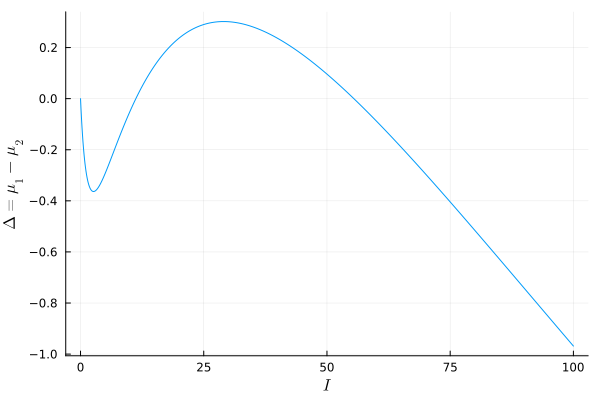

In [ ]:
using JuMP, Ipopt, Plots, MINPACK, LaTeXStrings

# Parameters
N = 2500
mu_m1 = 3
mu_m2 = 3.5
K_s = 6
D = 0.8
gamma_1 = 1.0
gamma_2 = 1
I_max = 100
theta_01 = 1
theta_02 = 1.75
K1 = 200
K2 = 45
alpha_1 = 0.09
alpha_2 = 0.1
t0 = 0
tf = 50

function theta(thetai_0,Ki,Ii)
    return thetai_0.*(Ki./(Ki.+Ii))
end

function mu_G1(I,Ii)
    return mu_m1.*(I.*theta(theta_01,K1,Ii)./(I.*theta(theta_01,K1,Ii).+K_s))
end

function mu_G2(I,Ii)
    return mu_m2.*(I.*theta(theta_02,K2,Ii)./(I.*theta(theta_02,K2,Ii).+K_s))
end

function mu_N1(I,Ii)
    return mu_G1(I,Ii).-alpha_1.*I.*theta(theta_01,K1,Ii)
end

function mu_N2(I,Ii)
    return mu_G2(I,Ii).-alpha_2.*I.*theta(theta_02,K2,Ii)
end


I_plot = LinRange(0,100,1000)

delta_plot=plot(I_plot, mu_N1(I_plot,I_plot)-mu_N2(I_plot,I_plot), xlabel = L"I", ylabel = L"Δ=μ_1 -μ_2", legend = false)
# À l'équilibre I = I_star

ΔI = 0.001
I_values = 0:ΔI:I_max

# Calcul des valeurs
μ1_values = mu_N1.(I_values)
μ2_values = mu_N2.(I_values)


Δ = μ1_values - μ2_values

Δ = μ1_values - μ2_values

I_barre = I_values[argmax(Δ)]
I_min = I_values[argmin(Δ[1:argmax(Δ)])]

println("I_min = ", I_min)
println("I_barre = ", I_barre)


display(delta_plot)

In [4]:
using JuMP, Ipopt, Plots, MINPACK, LaTeXStrings

#JuMP model, Ipopt solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 10))
set_optimizer_attribute(sys, "tol", 1e-3)
set_optimizer_attribute(sys, "constr_viol_tol", 1e-3)
set_optimizer_attribute(sys, "max_iter", 1000)
set_optimizer_attribute(sys, "check_derivatives_for_naninf", "yes")



# Variables
@variables(sys, begin
    Δt == (tf - t0) / N  # Time step
    0.0 ≤ x1[1:N+1]
    0.0 ≤ x2[1:N+1]
    0.0 ≤ I_star1[1:N+1]
    0.0 ≤ I_star2[1:N+1]
    I_min ≤ I[1:N+1] ≤ I_max
end)


(Δt, VariableRef[x1[1], x1[2], x1[3], x1[4], x1[5], x1[6], x1[7], x1[8], x1[9], x1[10]  …  x1[2492], x1[2493], x1[2494], x1[2495], x1[2496], x1[2497], x1[2498], x1[2499], x1[2500], x1[2501]], VariableRef[x2[1], x2[2], x2[3], x2[4], x2[5], x2[6], x2[7], x2[8], x2[9], x2[10]  …  x2[2492], x2[2493], x2[2494], x2[2495], x2[2496], x2[2497], x2[2498], x2[2499], x2[2500], x2[2501]], VariableRef[I_star1[1], I_star1[2], I_star1[3], I_star1[4], I_star1[5], I_star1[6], I_star1[7], I_star1[8], I_star1[9], I_star1[10]  …  I_star1[2492], I_star1[2493], I_star1[2494], I_star1[2495], I_star1[2496], I_star1[2497], I_star1[2498], I_star1[2499], I_star1[2500], I_star1[2501]], VariableRef[I_star2[1], I_star2[2], I_star2[3], I_star2[4], I_star2[5], I_star2[6], I_star2[7], I_star2[8], I_star2[9], I_star2[10]  …  I_star2[2492], I_star2[2493], I_star2[2494], I_star2[2495], I_star2[2496], I_star2[2497], I_star2[2498], I_star2[2499], I_star2[2500], I_star2[2501]], VariableRef[I[1], I[2], I[3], I[4], I[5], I[6],

In [5]:
# Objective
ϵ = 0.0001
@NLobjective(sys, Max, (x1[N+1] + ϵ) / (x2[N+1] + ϵ))


In [6]:
# Boundary constraints
@constraints(sys, begin
    con_x1, x1[1] == 0.4
    con_x2, x2[1] == 0.3
    con_I_s1, I_star1[1] == 10
    con_I_s2, I_star2[1] == 20
    con_I, I[1] == 10
end)


# Dynamics
@NLexpressions(sys, begin

    theta1[i = 1:N+1], theta_01*(K1/(K1+I_star1[i]))
    theta2[i = 1:N+1], theta_02*(K2/(K2+I_star2[i]))

    mu_g1[i = 1:N+1], mu_m1*((I[i]*theta1[i])/(I[i]*theta1[i]+K_s))
    mu_g2[i = 1:N+1], mu_m2*((I[i]*theta2[i])/(I[i]*theta2[i]+K_s))

    m1[i = 1:N+1], alpha_1*I[i]*theta1[i]
    m2[i = 1:N+1], alpha_2*I[i]*theta2[i]

    mu_n1[i = 1:N+1], mu_g1[i]-m1[i]
    mu_n2[i = 1:N+1], mu_g2[i]-m2[i]

    dx1[i = 1:N+1], (mu_n1[i]-D)*x1[i]
    dx2[i = 1:N+1], (mu_n2[i]-D)*x2[i]

    dI_star1[i = 1:N+1], gamma_1*(I[i]-I_star1[i])
    dI_star2[i = 1:N+1], gamma_2*(I[i]-I_star2[i])

end)

# Ajouter une contrainte explicite sur D pour éviter les valeurs négatives
@constraints(sys, begin
    con_I_pos[i = 1:N+1], I_max >= I[i] >= I_min # I_min # 0
end)

(ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.Interval{Float64}}, ScalarShape}[con_I_pos[1] : I[1] ∈ [2.641, 100], con_I_pos[2] : I[2] ∈ [2.641, 100], con_I_pos[3] : I[3] ∈ [2.641, 100], con_I_pos[4] : I[4] ∈ [2.641, 100], con_I_pos[5] : I[5] ∈ [2.641, 100], con_I_pos[6] : I[6] ∈ [2.641, 100], con_I_pos[7] : I[7] ∈ [2.641, 100], con_I_pos[8] : I[8] ∈ [2.641, 100], con_I_pos[9] : I[9] ∈ [2.641, 100], con_I_pos[10] : I[10] ∈ [2.641, 100]  …  con_I_pos[2492] : I[2492] ∈ [2.641, 100], con_I_pos[2493] : I[2493] ∈ [2.641, 100], con_I_pos[2494] : I[2494] ∈ [2.641, 100], con_I_pos[2495] : I[2495] ∈ [2.641, 100], con_I_pos[2496] : I[2496] ∈ [2.641, 100], con_I_pos[2497] : I[2497] ∈ [2.641, 100], con_I_pos[2498] : I[2498] ∈ [2.641, 100], con_I_pos[2499] : I[2499] ∈ [2.641, 100], con_I_pos[2500] : I[2500] ∈ [2.641, 100], con_I_pos[2501] : I[2501] ∈ [2.641, 100]],)

In [7]:

# Crank-Nicolson scheme
@NLconstraints(sys, begin
    con_dx1[i = 1:N], x1[i+1] == x1[i] + Δt * (dx1[i] + dx1[i+1]) / 2.0
    con_dx2[i = 1:N], x2[i+1] == x2[i] + Δt * (dx2[i] + dx2[i+1]) / 2.0
    con_dI_star1[i = 1:N], I_star1[i+1] == I_star1[i] + Δt * (dI_star1[i] + dI_star1[i+1]) / 2.0
    con_dI_star2[i = 1:N], I_star2[i+1] == I_star2[i] + Δt * (dI_star2[i] + dI_star2[i+1]) / 2.0
end)




(NonlinearConstraintRef{ScalarShape}[(x1[2] - (x1[1] + (Δt * (subexpression[20009] + subexpression[20010])) / 2.0)) - 0.0 = 0, (x1[3] - (x1[2] + (Δt * (subexpression[20010] + subexpression[20011])) / 2.0)) - 0.0 = 0, (x1[4] - (x1[3] + (Δt * (subexpression[20011] + subexpression[20012])) / 2.0)) - 0.0 = 0, (x1[5] - (x1[4] + (Δt * (subexpression[20012] + subexpression[20013])) / 2.0)) - 0.0 = 0, (x1[6] - (x1[5] + (Δt * (subexpression[20013] + subexpression[20014])) / 2.0)) - 0.0 = 0, (x1[7] - (x1[6] + (Δt * (subexpression[20014] + subexpression[20015])) / 2.0)) - 0.0 = 0, (x1[8] - (x1[7] + (Δt * (subexpression[20015] + subexpression[20016])) / 2.0)) - 0.0 = 0, (x1[9] - (x1[8] + (Δt * (subexpression[20016] + subexpression[20017])) / 2.0)) - 0.0 = 0, (x1[10] - (x1[9] + (Δt * (subexpression[20017] + subexpression[20018])) / 2.0)) - 0.0 = 0, (x1[11] - (x1[10] + (Δt * (subexpression[20018] + subexpression[20019])) / 2.0)) - 0.0 = 0  …  (x1[2492] - (x1[2491] + (Δt * (subexpression[22499] + sub

In [8]:

# Solves for the control and state
println("Solving...")
status = optimize!(sys)

if termination_status(sys) == MOI.OPTIMAL
    println("Solution is optimal")
elseif termination_status(sys) == MOI.LOCALLY_SOLVED
    println("Local solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("The model was not solved correctly.")
end
println("Objective value = ", objective_value(sys), "\n")

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
Δtt = value.(Δt)
t = (1:N+1)*Δtt; t = (t[1:end-1] + t[2:end])/2.0
xx1 = value.(x1); xx1 = (xx1[1:end-1] + xx1[2:end])/2.0
xx2 = value.(x2); xx2 = (xx2[1:end-1] + xx2[2:end])/2.0
II1 = value.(I_star1); II1 = (II1[1:end-1] + II1[2:end])/2.0
II2 = value.(I_star2); II2 = (II2[1:end-1] + II2[2:end])/2.0
II = value.(I); II = (II[1:end-1] + II[2:end])/2.0     
x =  [ [ xx1[i], xx2[i], II1[i] , II2[i], II[i] ] for i in 1:N ]
p = -[ [ dual(con_dx1[i]), dual(con_dx2[i]), dual(con_dI_star1[i]) , dual(con_dI_star2[i]) ] for i in 1:N ];



Solving...

List of options:

                                    Name   Value                # times used
            check_derivatives_for_naninf = yes                       1
                         constr_viol_tol = 0.001                     5
                                max_iter = 1000                      1
                      obj_scaling_factor = -1                        1
                             print_level = 10                        2
                                     tol = 0.001                     2

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number o

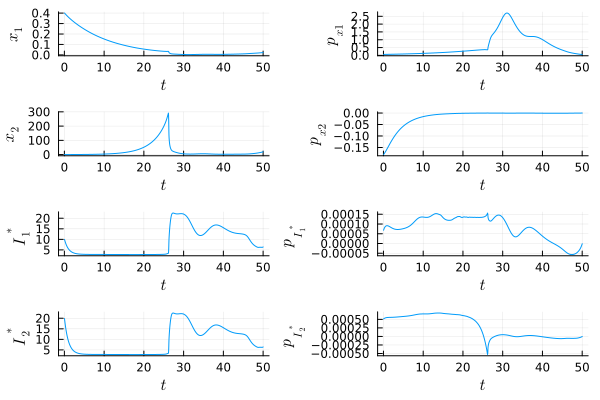

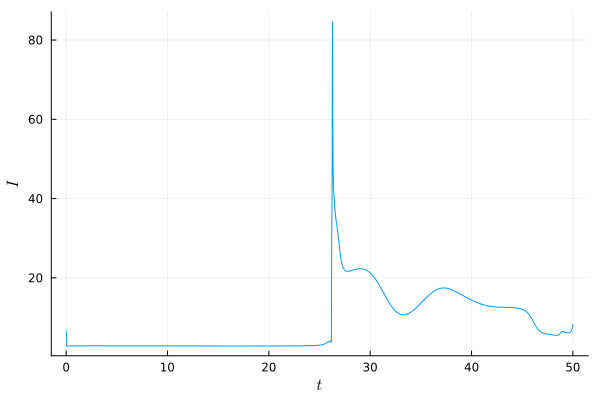

"/home/etudiant/M2 IM/PFE/fig2.pdf"

In [9]:
# Plots: state, adjoint state and control
x1_plot = plot(t, [ x[i][1] for i in 1:N ], xlabel = L"t", ylabel = L"x_1", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:N ], xlabel = L"t", ylabel = L"x_2", legend = false)
I1_plot = plot(t, [ x[i][3] for i in 1:N ], xlabel = L"t", ylabel = L"I_1^*", legend = false)
I2_plot = plot(t, [ x[i][4] for i in 1:N ], xlabel = L"t", ylabel = L"I_2^*", legend = false)
II_plot = plot(t, [ x[i][5] for i in 1:N ], xlabel = L"t", ylabel = L"I", legend = false)

px1_plot = plot(t, [ p[i][1] for i in 1:N ], xlabel = L"t", ylabel = L"p_{x1}", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:N ], xlabel = L"t", ylabel = L"p_{x2}", legend = false)
pI1_plot = plot(t, [ p[i][3] for i in 1:N ], xlabel = L"t", ylabel = L"p_{I_1^*}", legend = false)
pI2_plot = plot(t, [ p[i][4] for i in 1:N ], xlabel = L"t", ylabel = L"p_{I_2^*}", legend = false)
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, I1_plot, pI1_plot, I2_plot, pI2_plot, layout = (4,2))

display(x_plot) ; savefig(x_plot, "fig1.pdf")
display(II_plot) ; savefig(II_plot, "fig2.pdf")
# Correct the missing comma in the plot function